# News Clustering using KMeans Algorithm

In [1]:
import numpy as np
import pandas as pd
from time import time
import articles_data_py3 as articles_data
from pymongo import MongoClient

In [2]:
t0 = time()

## Load data from MongoDB 

In [3]:
client = MongoClient('mongodb://localhost:27017/somanews')
client.somanews.authenticate('ssomanews', 'ssomanews1029')
db = client.get_database('somanews')

crawled_collection = db.get_collection('crawledArticles')
clusters_collection = db.get_collection('articles')

## Select Categories
- 포함 : 경제, 문화, 건강, 과학, 사회, 정치, 스포츠
- 제외 : 종합, 정보없음, 인물, 사설

In [4]:
catelist_path = '../datastore/category.p'
headline_path = '../datastore/headline.p'

In [5]:
train = articles_data.find_recent_articles(crawled_collection, catelist_path)

## Preprocessing
1. Datetime (16-09-11 ~ 16-09-17)
2. Remove stopwords (regex, hanja)
3. POS Tagging with KoNLPy, Mecab
4. Using bigram

In [6]:
import datetime
from konlpy.tag import Mecab
import cnouns
import hanja
import re

In [7]:
mecab = Mecab()

In [8]:
def tokenize(data):
    return [' '.join(e for e in mecab.nouns(data))]

In [9]:
train['title_flat'] = train['title'].apply(lambda text: articles_data.remove_headlines(text, headline_path))
train['title_flat'] = train['title_flat'].apply(lambda text: cnouns.text_cleaning_without_special_ch(text))
train = train[train['title_flat']!='NaN']
title = [tokenize(each[1]['title_flat']) for each in train.iterrows()]

## Training
1. Feature extraction - TfidVectorizer
2. Decomposition - PCA
3. Cluster - KMeans

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [11]:
vectorizer = TfidfVectorizer(lowercase=False, ngram_range=(1,2))
title_flat = [item for sublist in title for item in sublist]
x_list = vectorizer.fit_transform(title_flat)

In [12]:
x_list_100d = PCA(n_components=100).fit_transform(x_list.toarray())
x_list_100d.shape

(2489, 100)

### Scoring

In [13]:
from sklearn.metrics import silhouette_samples, silhouette_score
from IPython.display import display, HTML
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### Best Silhoutte Score

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

In [15]:
best_score = 0.0
best_k = 0

In [16]:
k_list = []
score_list = []
for k in range(20, 35):
    km = KMeans(n_clusters=k, n_jobs=-1).fit(x_list_100d)
    score = silhouette_score(x_list_100d, km.labels_)
    if best_score < score:
        best_score = score
        best_k = k
    k_list.append(k)
    score_list.append(score)
print("In Clusters =", best_k, ", Best score is : %0.3f" % best_score)

In Clusters = 33 , Best score is : 0.194


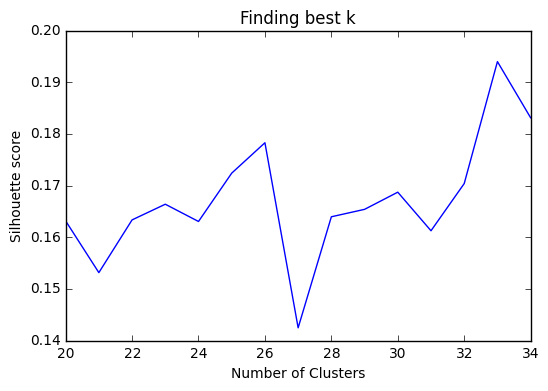

In [17]:
x = k_list
y = score_list
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette score')
plt.title('Finding best k')
plt.plot(x, y)
plt.show()

### K-Means Algorithm

In [18]:
km = KMeans(n_clusters=best_k, n_jobs=-1).fit(x_list_100d)
labels = km.labels_
centroids = km.cluster_centers_
print(km.inertia_)

227.106949759


In [19]:
x_list_vector = x_list_100d.tolist()
train = train.drop(['title_flat'], axis=1)
train['vector'] = x_list_vector
train['cluster'] = labels

## Choose Best Cluster
- Minimum inertia

In [20]:
sample_silhouette_values = silhouette_samples(x_list_100d, labels)
sample_silhouette_score = []
list_silhouette_score = []
best_cluster = []

for i in range(best_k):
    ith_cluster_silhouette_values = \
        sample_silhouette_values[labels == i]    
    list_silhouette_score.append(abs(ith_cluster_silhouette_values.mean()))

list_silhouette_score.sort(reverse=True)
sample_silhouette_score = list_silhouette_score[:12]

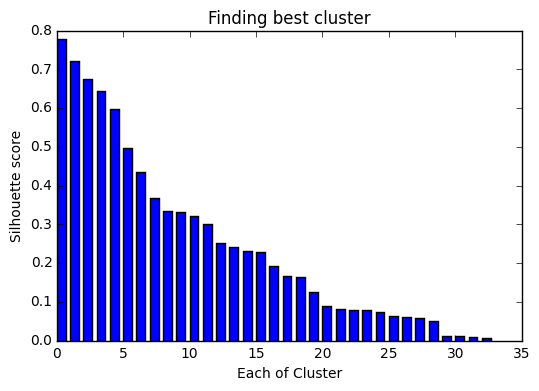

In [21]:
x = [x for x in range(best_k)]
y = list_silhouette_score
width = 1/1.5
plt.xlabel('Each of Cluster')
plt.ylabel('Silhouette score')
plt.title('Finding best cluster')
plt.bar(x, y, width)
plt.show()

In [22]:
sample_silhouette_score

[0.77691385483485942,
 0.72172832799999442,
 0.67420234698854031,
 0.64292597152903619,
 0.59798333780782686,
 0.49762088500883112,
 0.43545709821019979,
 0.36775518731652573,
 0.33537761846221298,
 0.33253188177036486,
 0.32125225666533613,
 0.30136862558408994]

In [23]:
for i in range(best_k):
    ith_cluster_silhouette_values = \
        sample_silhouette_values[labels == i]
        
    if abs(ith_cluster_silhouette_values.mean()) in sample_silhouette_score:
        best_cluster.append(i)

In [24]:
train = train[train['cluster'].isin(best_cluster)]
train.cluster.unique()

array([29, 25, 22, 10,  5, 27, 20, 28,  8, 17, 18, 31])

## Result

In [25]:
cluster_data = []

for cluster_index in range(best_k):
    if cluster_index in best_cluster:
        cluster_data.append(train[train['cluster'] == cluster_index])
    
for i, d in enumerate(cluster_data):
    print('Cluster %d:' % (i), 'Size %d' % (len(d)))

    display(d[['title', 'category']].sample(min(len(train.cluster.unique()), len(d))))
    print('\n\n')

Cluster 0: Size 12


,title,category
3173,해운대 ‘엘시티’ 이영복 회장 체포,사회 > 법원·검찰
3317,‘1000억 비자금’ 엘시티 이영복 체포,뉴스 > 정치 > 정치일반
713,‘엘시티 비자금’ 이영복 도피 도운 강남 유흥업소 직원 구속,사회 > 법원·검찰
3197,‘수백억 횡령’ 부산 엘시티 이영복 회장 검거,사회 > 사회일반
4099,부산 해운대 엘시티 이영복 회장 구속,사회 > 전국
4096,"해운대 엘시티 이영복 구속…검찰, 비자금 규모 등 집중 조사",사회 > 사건·사고
3218,‘비자금 의혹’ 엘시티 이영복 회장 체포,사회 > 법원·검찰
3712,"검찰, ‘엘시티’ 이영복 회장 영장 청구…횡령·사기 혐의",사회 > 사회일반
3510,"검찰, ‘엘시티’ 수사 본격화…이영복 회장 검거",사회 > 전국
3832,'엘시티 이영복 리스트' 있나… 與 중진의원 등 3~4명 거론,사회 > 법원ㆍ검찰ㆍ경찰





Cluster 1: Size 10


,title,category
1746,한진해운 화물 95.5% 하역… 물류대란 두달만에 마무리,뉴스 > 경제 > 경제일반
3157,한진해운 대량실직 현실로해상직원 580명 해고 통보,경제 > 경제일반
1417,"한진해운 이후, 韓 해운업은 어디로",마켓·비즈 > 경제일반
3169,"한진해운, 선원 640명 일괄 해고",마켓·비즈 > 경제일반
2790,"한진해운, 해상직원 600여명에 해고통보··· 대량실직 현실화",마켓·비즈 > 경제일반
1571,“제2의 한진해운 막으려면 해운·조선 자금 흐름 이어야”,마켓·비즈 > 경제일반
1415,한진해운 9월 말 이후 운송대금 583억여원 받아,경제 > 경제일반
1285,한진해운 물류대란 마무리 단계…“97척 중 3척 하역만 남아”,경제 > 경제일반
2821,"한진해운, 선원 600여명 일괄 해고 통보",경제 > 경제일반
3251,"한진해운, 해상직원 560명 일괄 해고",뉴스 > 경제 > 경제일반





Cluster 2: Size 13


,title,category
3159,대우조선 감자로 산은·금융위 수천억 허공에,경제 > 경제일반
654,"대우조선, 세계 첫 쇄빙LNG선 건조…8일 북극해로 출발",마켓·비즈 > 경제일반
3758,[경제계 인사]미래에셋대우,뉴스 > 경제 > 경제일반
3240,[경제계 인사]미래에셋대우,뉴스 > 경제 > 경제일반
322,산은-수은 “대우조선 3조 추가 자본확충”,뉴스 > 경제 > 경제일반
474,[단독] 대우조선 살리기 계획 3조원 펑크,경제 > 경제일반
3166,대우조선 자본확충안…노조 반대로 무산 위기,마켓·비즈 > 경제일반
3927,“일단 살려놓고 보자”··대우조선해양 ‘폭탄 돌리기’ 나선 정부,마켓·비즈 > 경제일반
3252,"대우조선 채권단 “2조8000억 자본확충, 노조 동의없인 무효”",뉴스 > 경제 > 경제일반
2512,“대우조선노조 자구안 동참 동의서 10일까지 제출 안하면 지원 중단”,뉴스 > 경제 > 경제일반





Cluster 3: Size 14


,title,category
3457,‘한·일 정보협정’ 법제처에 심사 의뢰 국방부 “다음주 협정 가서명”,정치 > 국방·북한
3187,“한·일 군사협정 강행 땐 국방장관 해임건의”,정치 > 국회·정당
1298,"이 와중에…국방부, ‘한일 군사협정’ 2차 협상도 강행",정치 > 국방·북한
1320,"정부, '최순실 게이트' 틈타 한일군사정보보호협청 체결 서둘러",정치 > 국방·외교
3728,한일군사정보협정 11월 셋째주초 가서명,뉴스 > 정치 > 국방
1632,한·일 군사정보협정 ‘속전속결’ 체결 강행,정치 > 국방·외교
3705,한·일 군사정보협정 ‘군사작전’ 하듯,정치 > 국방·외교
1568,한일 군사정보협정 가속…야 “어수선한 틈 밀어붙이기” 반발,정치 > 국방·북한
3660,국방부 “다음주 한-일 정보협정 가서명”…국정 혼란 와중에 ‘강행’,정치 > 국방·북한
1848,韓日 군사정보협정 9일 2차협의… 타결 임박,뉴스 > 사회 > 사회일반





Cluster 4: Size 8


,title,category
1441,[속보]삼척 촛대바위서 사고···구조 나선 해경 특공대원·근로자 3명 사망·실종,사회 > 사건·사고
3825,딸 생일날 '먼 길' 떠난 해경 특공대,사회
3480,삼척 순직 해경 특공대원 ‘LG 의인상’,경제 > 경제일반
1850,"근로자 구하던 해경 2명, 파도 휩쓸려 사망-실종",뉴스 > 사회 > 사회일반
3403,삼척 갯바위 고립된 노동자 구조중 실종된 해경 특공대원 숨진 채 발견,사회 > 사건·사고
1495,삼척서 파도에 휩쓸린 해경특공대원 등 2명 사망·1명 실종,사회 > 전국
1614,삼척 갯바위 공사 중 파도에 고립…노동자 1명·구조 나선 해경 1명 사망,사회 > 사건·사고
1909,"파도 휩쓸린 근로자 구하다… 해경특공대 1명 사망, 1명 실종",사회 > 사건ㆍ사고





Cluster 5: Size 5


,title,category
956,[속보]'최순실 게이트' 송성각 전 콘텐츠진흥원장 체포,사회 > 법원·검찰
3196,[속보] ‘차은택 은사’ 송성각 전 콘텐츠진흥원장 영장 발부,사회 > 사회일반
963,"‘최순실 의혹’ 수사 검찰, 뇌물·강요혐의로 송성각 전 콘텐츠진흥원장 체포",사회 > 사회일반
3204,[속보]‘최순실 게이트’ 송성각 전 콘텐츠진흥원장 구속,사회 > 법원·검찰
964,‘차은택 측근’ 송성각 전 콘텐츠진흥원장 체포,사회 > 사회일반





Cluster 6: Size 32


,title,category
3081,서울~부산 거리 1.4배 해안선 13년 간 개발로 훼손,사회 > 사회일반
652,"마을과 함께하는 방과후학교, 내년 서울 9개구 시범운영",사회 > 교육
282,[아파트 시세]서울 아파트값 상승률 0.06%… 일주일새 절반 뚝,뉴스 > 경제 > 경제일반
2252,"강원 인재양성 요람, 제2강원학사 서울 강북에 문 연다",사회 > 전국
3443,‘서울 지하철 통합’ 노사정 합의···4년간 1029명 감축키로,전국 > 서울·수도권 서울 경기 인천
3237,"[화제의 분양현장]‘11·3 규제’ 피하고, 서울 강남 접근성 뛰어난 지역은…",뉴스 > 경제 > 부동산
1912,"서울~원주, 이제 54분이면 도착",사회 > 교통ㆍ관광ㆍ항공
3734,[굿바이 서울!/정은영]지역 자부심을 키우는 토박이 기업,뉴스 > 경제 > 경제일반
3780,서울지하철 ‘메트로-도시철도’ 통합 합의,뉴스 > 사회 > 사회일반
1833,‘감정노동자 권리장전’ 서울 첫 제정,뉴스 > 사회 > 사회일반





Cluster 7: Size 11


,title,category
412,美 누가 이겨도 ‘보호무역’… 트럼프 당선땐 브렉시트급 충격,뉴스 > 경제 > 경제일반
2118,트럼프 우세에 국내 금값 급등…브렉시트 이후 최대폭,경제 > 경제일반
2991,“브렉시트 학습효과·‘통합’ 안도감으로 시장 회복”,경제 > 증권
3070,"브렉시트 충격받았던 영국인들이 미국인들에게 보내는 ""트럼프 시대를 견뎌내는 법""",국제 > 국제일반
370,메이 “브렉시트 결정 되돌리는 일 없을 것”,뉴스 > 국제 > 국제일반
2804,영국 브렉시트와 트럼프 승리의 5가지 공통점,국제 > 국제일반
3952,"“트럼프 당선과 브렉시트, 고립적 보수주의의 부활”",사회 > 사회일반
184,[2016 미국의 선택]‘미국판 브렉시트’ 일어날지도 모른다,국제 > 미국·중남미
637,'제2의 브렉시트 일어나나'...세계는 미국 대선을 어떻게 지켜봤나,국제 > 국제일반
3151,“브렉시트 학습 효과·통합 메시지에 투자심리 회복”,경제 > 증권





Cluster 8: Size 3


,title,category
1249,"[박근혜·최순실 게이트]‘박정희 미화’ 소설 쓴 류철균, 박 대통령이 만든 재단 이사였다",정치 > 정치일반
942,"[박근혜·최순실 게이트]‘박정희 미화’ 소설 쓴 류철균, 박 대통령이 만든 재단 이사였다",정치 > 정치일반
962,"[단독]'박정희 미화' 소설 쓴 류철균, 박 대통령이 만든 재단 이사였다",사회 > 사회일반





Cluster 9: Size 12


,title,category
1125,"“朴대통령, 국회에 총리 추천 맡겨야… 빨리 양보하는게 최선”",뉴스 > 정치 > 정치일반
2344,야3당 ‘국회 추천 총리’ 공식 거부,정치 > 국회·정당
1419,안철수 “朴대통령의 국회 총리 추천 수용은 ‘시간끌기용’…완전히 국정 손 떼고 물러...,정치 > 정치일반
1132,"""김병준 철회하고, 國會가 총리 추천하자""",정치
1115,“국회추천 총리에 내치 전권만 주면 돼”… 민주당 숨고르기,뉴스 > 정치 > 정치일반
1879,朴대통령 “국회 추천 총리가 내각 통할” 野 “권한 모호… 2선후퇴 먼저” 또 거부,뉴스 > 정치 > 정치일반
2628,'총리 추천' 거부하고 거리로 나서는 3野,정치
1890,韓·日 군사협정 서두르는 정부… 野 추천 총리가 받아들일까,정치 > 외교
2453,야 3당 “박 대통령 결단 먼저”…‘총리 추천 제안’ 공식 거부,정치 > 국회·정당
1319,"박대통령 “국회 추천 총리, 내각 통할하도록 하겠다”",정치 > 청와대





Cluster 10: Size 17


,title,category
2414,"‘전생 체험’ 박승주, 국민안전처 장관 후보자 자진사퇴",정치 > 정치일반
686,"'굿판 참여' 박승주 안전처 장관 내정자 ""환태평양 지진대가 활동해서"" 해명",사회 > 사회일반
589,"‘전생 안전처’ 장관? 박승주 후보자, 전생 체험 고백 책도 썼다",사회 > 사회일반
2403,‘굿판·전생 체험’ 박승주 안전처 장관 내정자 자진 사퇴,정치 > 정치일반
708,박승주 국민안전처 장관 내정자 ‘광화문 굿판’ 참석 해명 들어보니,사회 > 사회일반
2399,"[속보] 박승주 안전처 장관 내정자, 자진 사퇴",정치 > 정치일반
503,안전처 장관 내정자 “명상 통해 47가지 모습으로 지구 왔다”,정치 > 정치BAR
2577,‘굿판 논란‘ 박승주 안전처장관 후보자 자진 사퇴,뉴스 > 정치 > 국회
813,[카드뉴스] 장관 내정자와 굿판,사회 > 카드뉴스
1012,[횡설수설/송평인]안전처 장관 후보자의 굿판,뉴스 > 정치 > 정치일반





Cluster 11: Size 10


,title,category
2380,미국사회 ‘트럼프 쇼크’,국제 > 미국·중남미
3955,최순실 게이트에 트럼프 쇼크까지…‘10년 위기설’ 현실되나,사회 > 사회일반
2836,미국-멕시코-캐나다 신문 1면으로 본 ‘트럼프 쇼크’,국제 > 미국·중남미
3254,"하루짜리 ‘트럼프 쇼크’… 亞증시, 親시장 기대감에 반등",뉴스 > 경제 > 경제일반
3466,IBK증권 “‘트럼프 쇼크 ’로 인한 불확실성 2017년까지 이어질 것”,마켓·비즈 > 경제일반
2205,트럼프 쇼크에 증시 ‘충격’…코스피 1950선 추락,경제 > 증권
2987,‘트럼프 쇼크’ 자동차·철강·가전 직격탄,경제 > 경제일반
3192,‘트럼프 쇼크’마저 위기탈출용 카드로…청 ‘위험한 여론전’,정치 > 청와대
2304,"美 대선 대이변··· 금융시장 ‘트럼프 쇼크’, 코스피 45P 폭락",마켓·비즈 > 경제일반
2750,‘트럼프 쇼크’ 하루만에 진정?···코스피 1990선 회복,마켓·비즈 > 경제일반


## Save Dataframe to MongoDB

In [26]:
client = MongoClient('mongodb://localhost:27017/somanews')
client.somanews.authenticate('ssomanews', 'ssomanews1029')
db = client.get_database('somanews')
articles = db.get_collection('articles')

In [27]:
articles.insert_many(train.to_dict(orient='records'))
client.close()

In [28]:
print("Done in %0.3fs." % (time() - t0))

Done in 93.898s.
